In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

import os

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, optimizers, losses, callbacks
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input, BatchNormalization
from tensorflow.keras.layers import\
    Conv2D, ZeroPadding2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K

from IPython import display

from sklearn.model_selection import train_test_split

# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
model = keras.models.load_model('drive/MyDrive/MUS106/GenreSpectrogramClassifier')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 432, 288, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 432, 288, 8)      32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 432, 288, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 216, 144, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 216, 144, 16)      1168      
                                                                 
 batch_normalization_1 (Batc  (None, 216, 144, 16)     6

# Saliency Maps

In [3]:
def getSpectrogram(file_path):
    audio, sr = librosa.load(file_path)

def loadImg(img_path, shape=(432, 288)):
    img = image.load_img(img_path, target_size=shape)
    # (height, width, channels)
    img_tensor = image.img_to_array(img)
    # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    # imshow expects values in the range [0, 1]

    return img_tensor

In [4]:
img1 = loadImg('./classical00038.png')
img2 = loadImg('./rock00008.png')
img1.shape

(1, 432, 288, 3)

In [5]:
last_conv_layer = list(filter(
    lambda x: isinstance(x, tf.keras.layers.Conv2D),
    model.layers
))[-1]

activ_model = Model(inputs=model.inputs, outputs=last_conv_layer.output)

In [6]:
# Helper function that takes the gradients and
# transforms them into values that can we plotted using matplotlib
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.25
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x



In [7]:
@tf.custom_gradient
def guidedBackprop(x):
    def grad(dy):
        dy = tf.cast(dy, "float32")
        new_x = tf.cast(x, "float32")
        return tf.where(dy < 0, 0, dy) * tf.where(new_x < 0, 0.0, 1.0)
    return tf.nn.relu(x), grad

In [8]:
def getFeatureImg(img, model, gradient):
    # change all relu in activation layers to deconvolution
    layer_dict = [layer for layer in model.layers[1:]
                  if hasattr(layer, 'activation')]
    for layer in layer_dict:
        if layer.activation == tf.keras.activations.relu:
            layer.activation = gradient

    # Open gradient tape and get the gradient of the layer with respect
    # to the input image
    with tf.GradientTape() as tape:
        inputs = tf.cast(img, tf.float32)
        tape.watch(inputs)
        outputs = model(inputs)
    gg = tape.gradient(outputs, inputs)[0]
    return np.flip(deprocess_image(np.array(gg)), -1)

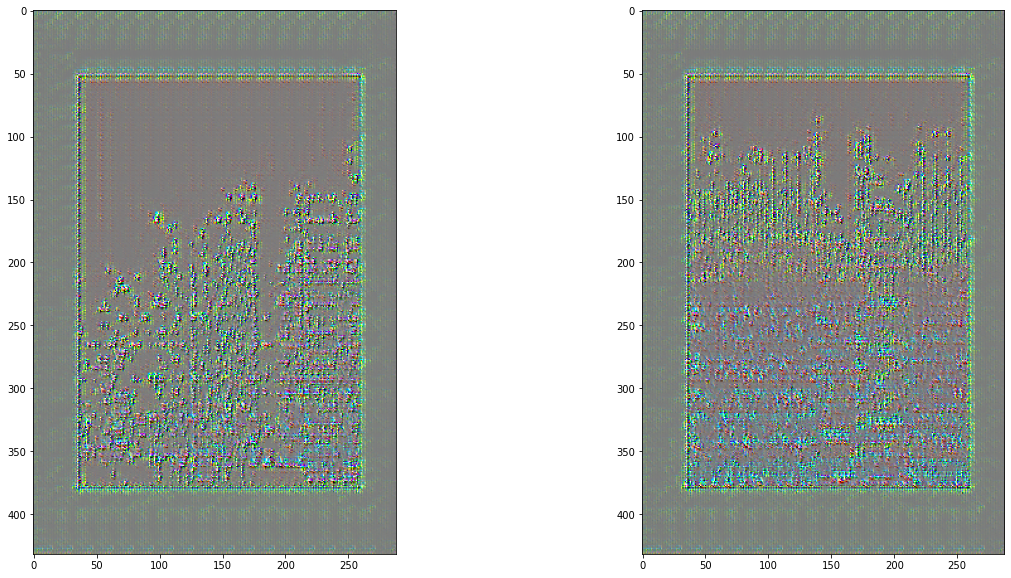

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(getFeatureImg(img1, activ_model, guidedBackprop))
ax[1].imshow(getFeatureImg(img2, activ_model, guidedBackprop))